# Random numbers and probability models

In [108]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from numba import jit

## Python analog of R random number functions

In [113]:
%load_ext rpy2.ipython

### R functions

In [114]:
%%R

n <- 5
xs <- c(0.1, 0.5, 0.9)
print(dbeta(xs, 0.5, 0.5))
print(pbeta(xs, 0.5, 0.5))
print(qbeta(xs, 0.5, 0.5))
print(rbeta(n, 0.5, 0.5))

[1] 1.0610330 0.6366198 1.0610330
[1] 0.2048328 0.5000000 0.7951672
[1] 0.02447174 0.50000000 0.97552826
[1] 0.7208962 0.2096310 0.1825803 0.5222808 0.4206676


### Scipy functions

In [115]:
n = 5
xs = [0.1, 0.5, 0.9]
rv = stats.beta(a=0.5, b=0.5)

print(rv.pdf(xs)) # equivalent of dbeta
print(rv.cdf(xs)) # equivalent of pbeta
print(rv.ppf(xs)) # equvialent of qbeta
print(rv.rvs(n))  # equivalent of rbeta

[ 1.06103295  0.63661977  1.06103295]
[ 0.20483276  0.5         0.79516724]
[ 0.02447174  0.5         0.97552826]
[ 0.01639756  0.92988715  0.37238013  0.88664857  0.05517638]


## Why are random numbers useful?

If we can draw an arbitrary number of random deviates from a distribution, in some sense, we know everyting there is to know about the distribution.

#### Example 

Questions about IQ assuming a mean of 100 and standard deviaiton of 15.

In [2]:
μ = 100
σ = 15
n = 10000
x = np.random.normal(μ, σ, n)

In [3]:
# What fraction of people have IQs greater than 140?

sum(x > 140)/n

0.0035999999999999999

In [4]:
# What fraction of people have IQs between 80 and 90?

sum((x > 80) & (x < 90))/n

0.16370000000000001

In [5]:
# What is the average IQ?

sum(x)/n

99.903139729220229

In [7]:
# What is the median IQ?

y = sorted(x)
0.5*(y[n//2] + y[n//2+1])

99.922944298137551

In [8]:
# What IQ do I need to be in the top 5%?

y[int(0.95*n)]

124.45881549409874

## Where do random numbers in the computer come from?

While psuedorandom numbers are generated by a deterministic algorithm, we can mostly treat them as if they were true random numbers and we will drop the "pseudo" prefix. Fundamentally, the algorithm generates random integers which are then normalized to give a floating point number from the standard uniform distribution. Random numbers from other distributions are in turn generated using these uniform random deviates, either via general (inverse transform, accept/reject, mixture representations) or specialized ad-hoc (e.g. Box-Muller) methods.

### Generating standard uniform random numbers

#### Linear congruential generators (LCG)

$z_{i+1} = (az_i + c) \mod m$

Hull-Dobell Theorem: The LCG will have a full period for all seeds if and only if

- $c$ and $m$ are relatively prime,
- $a - 1$ is divisible by all prime factors of $m$
- $a - 1$ is a multiple of 4 if $m$ is a multiple of 4.

The number $z_0$ is called the *seed*, and setting it allows us to have a reproducible sequence of "random" numbers. The LCG is typically coded to return $z/m$, a floating point number in (0, 1). This can be scaled to any other range $(a, b)$.

Note that most PRNGs now use the [Mersenne twister](http://www.math.sci.hiroshima-u.ac.jp/~m-mat/MT/ARTICLES/mt.pdf), but the LCG is presented because the LCG code much easier to understand and all we hope for is some appreciation for how apparently random sequences can be generated from a deterministic iterative scheme.

In [98]:
def lcg(m=2**32, a=1103515245, c=12345):
    lcg.current = (a*lcg.current + c) % m
    return lcg.current/m

In [99]:
# setting the seed
lcg.current = 1

In [100]:
[lcg() for i in range(10)]

[0.25693503906950355,
 0.5878706516232342,
 0.15432575810700655,
 0.767266943352297,
 0.9738139626570046,
 0.5858681506942958,
 0.8511155843734741,
 0.6132153405342251,
 0.7473867232911289,
 0.06236015981994569]

### Inverse transform method

Once we have standard uniform numbers, we can often generate random numbers from other distribution using the inverse transform method. Recall that if $X$ is a continuous random variable with CDF $F_X$, then $Y = F_X(X)$ has the standard uniform distribution. Inverting this suggests that if $Y$ comes from a standard uniform distribution, then $F_X^{-1}(Y)$ has the same distribution as $X$. The inverse transform method is used below to generate random numbers from the exponential distribution.

In [116]:
def expon_pdf(x, lmabd=1):
    """PDF of exponential distribution."""
    return lmabd*np.exp(-lmabd*x)

def expon_cdf(x, lambd=1):
    """CDF of exponetial distribution."""
    return 1 - np.exp(-lambd*x)

def expon_icdf(p, lambd=1):
    """Inverse CDF of exponential distribution - i.e. quantile function."""
    return -np.log(1-p)/lambd

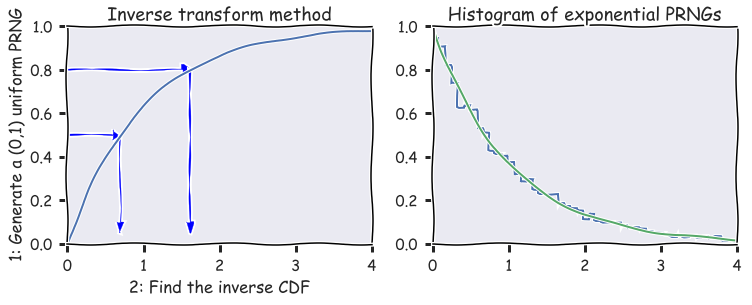

In [117]:
import scipy.stats as stats

dist = stats.expon()
x = np.linspace(0,4,100)
y = np.linspace(0,1,100)

with plt.xkcd():
    plt.figure(figsize=(12,4))
    plt.subplot(121)
    plt.plot(x, expon_cdf(x))
    plt.axis([0, 4, 0, 1])
    for q in [0.5, 0.8]:
        plt.arrow(0, q, expon_icdf(q)-0.1, 0, head_width=0.05, head_length=0.1, fc='b', ec='b')
        plt.arrow(expon_icdf(q), q, 0, -q+0.1, head_width=0.1, head_length=0.05, fc='b', ec='b')
    plt.ylabel('1: Generate a (0,1) uniform PRNG')
    plt.xlabel('2: Find the inverse CDF')
    plt.title('Inverse transform method');

    plt.subplot(122)
    u = np.random.random(10000)
    v = expon_icdf(u)
    plt.hist(v, histtype='step', bins=100, normed=True, linewidth=2)
    plt.plot(x, expon_pdf(x), linewidth=2)
    plt.axis([0,4,0,1])
    plt.title('Histogram of exponential PRNGs');

#### Inverse transform from sample data

Suppose we have some random samples with an unknown distribution. We can still use the inverse transform method to create a random number generator from a random sample, by estimating the inverse CDF function using interpolation.

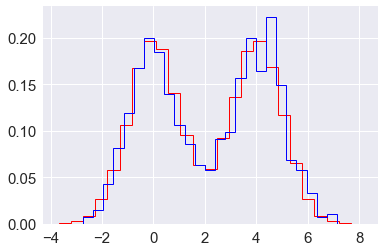

In [118]:
from scipy.interpolate import interp1d
from statsmodels.distributions.empirical_distribution import ECDF

# Make up some random data
x = np.concatenate([np.random.normal(0, 1, 10000), 
                    np.random.normal(4, 1, 10000)])

ecdf = ECDF(x)
inv_cdf = interp1d(ecdf.y, ecdf.x, bounds_error=False, assume_sorted=True)
r = np.random.uniform(0, 1, 1000)
ys = inv_cdf(r)

plt.hist(x, 25, histtype='step', color='red', normed=True, linewidth=1)
plt.hist(ys, 25, histtype='step', color='blue', normed=True, linewidth=1);

### Box-Muller for generating normally distributed random numbers

The Box-Muller transform starts with 2 random uniform numbers $u$ and $v$
- Generate an exponentially distributed variable $r^2$ from $u$ using the inverse transform method
- This means that $r$ is an exponentially distributed variable on $(0, \infty)$
- Generate a variable $\theta$ uniformly distributed on $(0, 2\pi)$ from $v$ by scaling
- In polar coordinates, the vector $(r, \theta)$ has an independent bivariate normal distribution
- Hence the projection onto the $x$ and $y$ axes give independent univariate normal random numbers

Note:

- Normal random numbers can also be generated using the *general* inverse transform method (e.g. by approximating the inverse CDF with a polynomial) or the rejection method (e.g. using the exponential distribution as the sampling distribution). 
- There is also a variant of Box-Muller that does not require the use of (expensive) trigonometric calculations.

In [86]:
n = 1000
u1 = np.random.random(n)
u2 = np.random.random(n)
r_squared = -2*np.log(u1)
r = np.sqrt(r_squared)
theta = 2*np.pi*u2
x = r*np.cos(theta)
y = r*np.sin(theta)

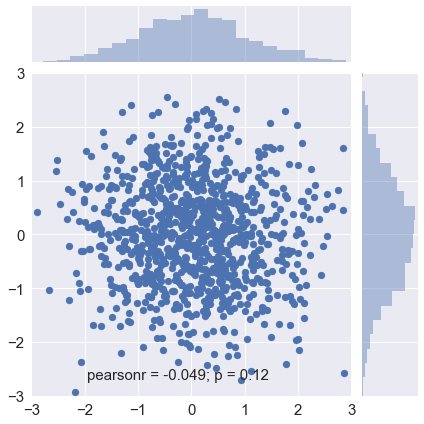

In [96]:
g = sns.jointplot(x, y, kind='scatter', xlim=(-3,3), ylim=(-3,3))
pass

### Generate univariate random normal deviates

In [66]:
@jit(nopython=True)
def box_muller(n):
    """Generate n random normal deviates."""
    
    u1 = np.random.random((n+1)//2)
    u2 = np.random.random((n+1)//2)
    r_squared = -2*np.log(u1)
    r = np.sqrt(r_squared)
    theta = 2*np.pi*u2
    x = r*np.cos(theta)
    y = r*np.sin(theta)
    z = np.empty(n)
    z[:((n+1)//2)] = x
    z[((n+1)//2):] = y
    return z[:n]

### Generating multivariate normal random deviates

In [67]:
@jit(nopython=True)
def mvn(mu, sigma, n=1):
    """Generate n samples from multivarate normal with mean mu and covariance sigma."""
    
    A = np.linalg.cholesky(sigma)
    p = len(mu)
    
    zs = np.zeros((n, p))
    for i in range(n):
        z = box_muller(p)
        zs[i] = mu + A@z    
    return zs

In [105]:
mu = 4.0*np.ones(2)
sigma = np.array([[1,0.6], [0.6, 1]])

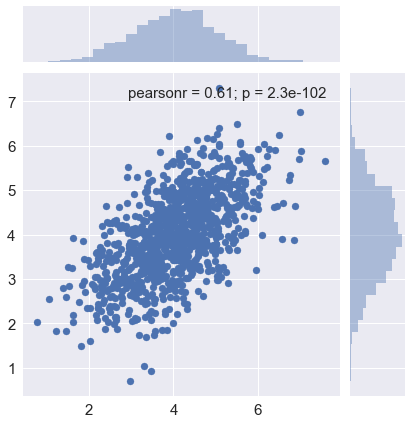

In [106]:
n = 1000
x, y = mvn(mu, sigma, n).T
g = sns.jointplot(x, y, kind='scatter')
pass
pass

## Rejection sampling

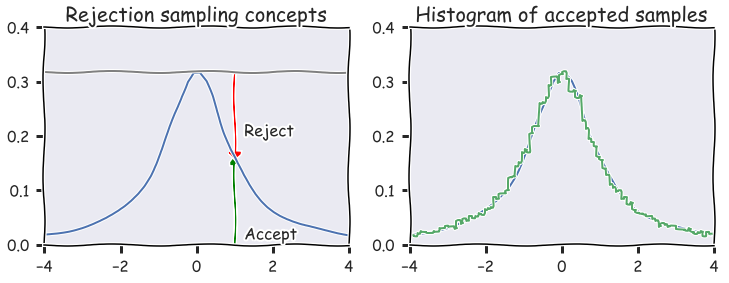

In [109]:
# Suppose we want to sample from the truncated Cauchy distribution 
# We use the uniform as a proposal distibution (highly inefficient)

x = np.linspace(-4, 4)

dist = stats.cauchy()
upper = dist.pdf(0)

with plt.xkcd():
    plt.figure(figsize=(12,4))
    plt.subplot(121)
    plt.plot(x, dist.pdf(x))
    plt.axhline(upper, color='grey')
    px = 1.0
    plt.arrow(px,0,0,dist.pdf(1.0)-0.01, linewidth=1,
              head_width=0.2, head_length=0.01, fc='g', ec='g')
    plt.arrow(px,upper,0,-(upper-dist.pdf(px)-0.01), linewidth=1, 
              head_width=0.3, head_length=0.01, fc='r', ec='r')
    plt.text(px+.25, 0.2, 'Reject', fontsize=16)
    plt.text(px+.25, 0.01, 'Accept', fontsize=16)
    plt.axis([-4,4,0,0.4])
    plt.title('Rejection sampling concepts', fontsize=20)

    plt.subplot(122)
    n = 100000
    # generate from sampling distribution
    u = np.random.uniform(-4, 4, n)
    # accept-reject criterion for each point in sampling distribution
    r = np.random.uniform(0, upper, n)
    # accepted points will come from target (Cauchy) distribution
    v = u[r < dist.pdf(u)]

    plt.plot(x, dist.pdf(x), linewidth=2)

    # Plot scaled histogram 
    factor = dist.cdf(4) - dist.cdf(-4)
    hist, bin_edges = np.histogram(v, bins=100, normed=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2.
    plt.step(bin_centers, factor*hist, linewidth=2)

    plt.axis([-4,4,0,0.4])
    plt.title('Histogram of accepted samples', fontsize=20);

### Mixture representations

Sometimes, the target distribution from which we need to generate random numbers can be expressed as a mixture of "simpler" distributions that we already know how to sample from

$$
f(x) = \int{g(x\,|\,y)p(y) dy}
$$

For example, if $y$ is drawn from the $\chi_\nu^2$ distribution, then $\mathcal{N}(0, \nu/y)$ is a sample from the Student's T distribution with $\nu$ degrees of freedom.

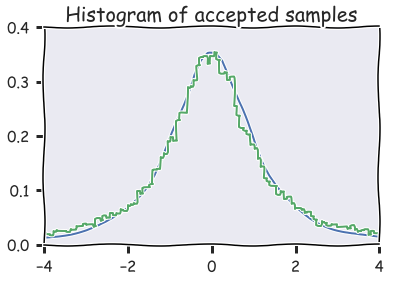

In [110]:
n = 10000
df = 2
dist = stats.t(df=df)
y = stats.chi2(df=df).rvs(n)
r = stats.norm(0, df/y).rvs(n)

with plt.xkcd():
    plt.plot(x, dist.pdf(x), linewidth=2)

    # Plot scaled histogram 
    factor = dist.cdf(4) - dist.cdf(-4)
    hist, bin_edges = np.histogram(v, bins=100, normed=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2.
    plt.step(bin_centers, factor*hist, linewidth=2)

    plt.axis([-4,4,0,0.4])
    plt.title('Histogram of accepted samples', fontsize=20);

## Using the `numpy.random` and `scipy.stats` PRNGs

From this part onwards, we will assume that there is a library of PRNGs that we can use - either from `numpy.random` or scipy.stats which are both based on the Mersenne Twister, a high-quality PRNG for random integers. The `numpy` versions simply generate random deviates while the `scipy` versions will also provide useful functions related to the distribution, e.g. PDF, CDF and quantiles.

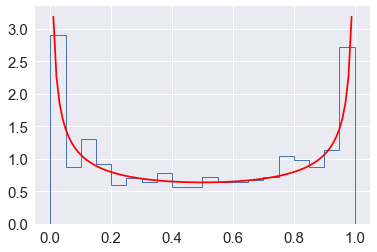

In [111]:
import numpy.random as rng

# Histogram of beta distribution
rs = rng.beta(a=0.5, b=0.5, size=1000)
plt.hist(rs, bins=20, histtype='step', normed=True, linewidth=1)

# PDF for the beta distribution
xs = np.linspace(0, 1, 100)
plt.plot(xs, stats.beta.pdf(xs, a=0.5, b=0.5), color='red')
pass